In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action='ignore')
from imblearn.over_sampling import RandomOverSampler

In [11]:
df = pd.read_csv('signal-data.csv')
df.head()


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


### Preparing the data for preprocessing

In [13]:
df.isna().sum().sum()

41951

In [14]:
missing = df.columns[df.isna().mean() >= 0.25]
missing.value_counts().sum()

32

#### The above columns have more than 25% null values, and shall be dropped. 
#### The column 'Time' will also serve no purpose, and shall be dropped. 
#### All the remaining values shall be imputed with Median.

In [15]:
df = df.drop('Time', axis=1)
    
df = df.drop(missing, axis=1)

for column in df.columns:
        df[column] = df[column].fillna(df[column].mean())

#### We shall change labels for Pass/Fail column to make it more understandable 

#### 1 = PASS, 0 = FAIL

In [16]:
df['Pass/Fail'] = df['Pass/Fail'].replace({-1: "1", 1: "0"})

In [17]:
df.shape

(1567, 559)

TypeError: Horizontal orientation requires numeric `x` variable.

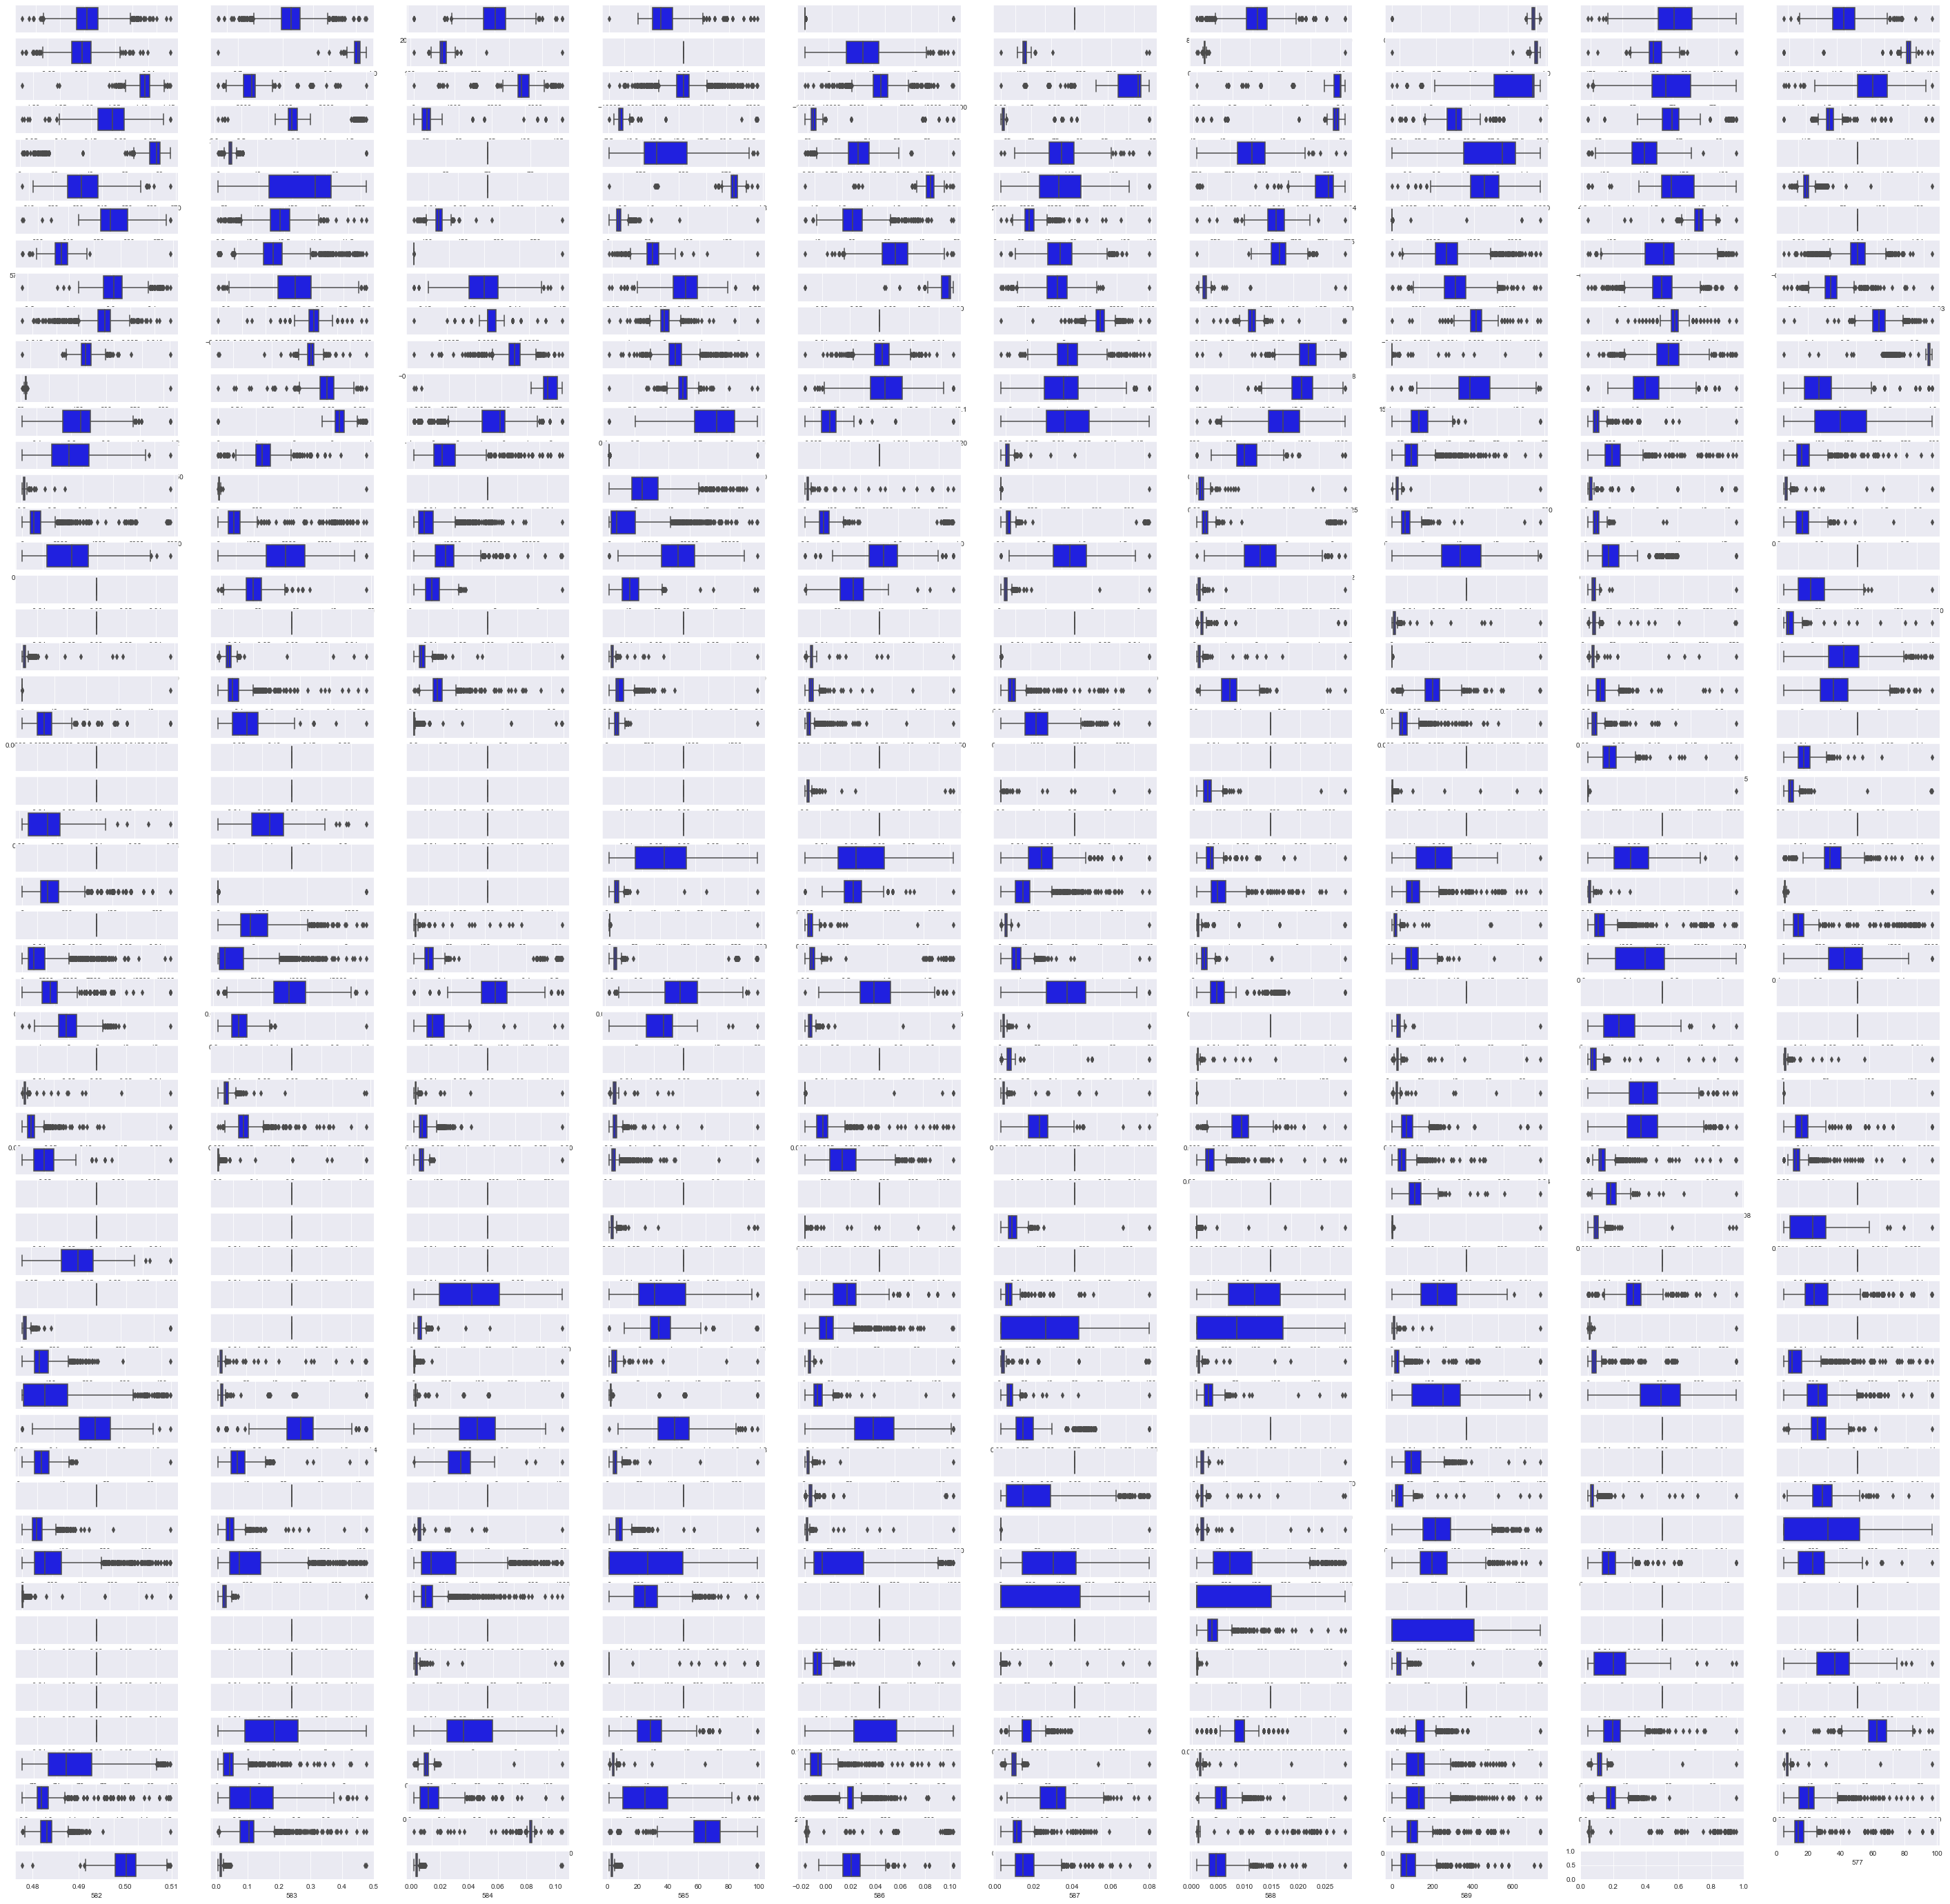

In [18]:
plt.figure(figsize=(50, 50))
col = 1
for i in df.columns:
    plt.subplot(56,10, col)
    sns.boxplot(df[i],color='blue')
    col += 1


## Segregating predictors vs target attributes

In [19]:
X = df.drop('Pass/Fail', axis=1)
y = df['Pass/Fail']

## Checking for target balancing and fixing it if found imbalanced.

1    1463
0     104
Name: Pass/Fail, dtype: int64


<AxesSubplot:ylabel='Pass/Fail'>

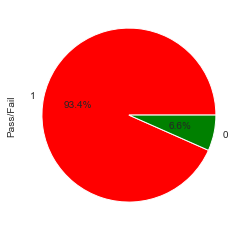

In [20]:
print (y.value_counts())

y.value_counts().plot.pie(autopct='%1.1f%%', colors=('red','green'))


#### We can see there is class imbalance in the target dataset
### Performing Train Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=1)

In [22]:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train.ravel())

1    1097
0    1097
dtype: int64


<AxesSubplot:ylabel='None'>

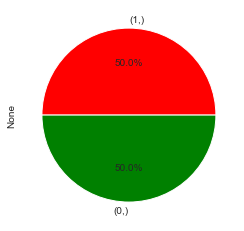

In [23]:
print (pd.DataFrame(y_train_smote).value_counts())

pd.DataFrame(y_train_smote).value_counts().plot.pie(autopct='%1.1f%%', colors=('red','green'))


#### We have cleared the imbalance.
## Model Training, Testing, Tuning.

In [24]:
def evaluate_model(model, X_test, y_test):
    
    acc = model.score(X_test, y_test)
    print("Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=['1', '0'])
    clr = classification_report(y_test, y_pred, labels=['1', '0'])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    plt.yticks(ticks=[0.5, 1.5], labels=["PASS", "FAIL"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

Accuracy: 67.86%


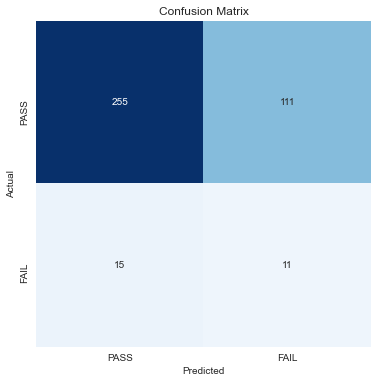

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.94      0.70      0.80       366
           0       0.09      0.42      0.15        26

    accuracy                           0.68       392
   macro avg       0.52      0.56      0.48       392
weighted avg       0.89      0.68      0.76       392



In [25]:
model = LogisticRegression()
model.fit(X_train_smote, y_train_smote)

evaluate_model(model, X_test, y_test)

#### With LogisticRegression Model we are getting accuracy of 67%, but it is performing poorly on determining Fail predictions. 

## Using GRID SEARCH CV and Random Grid Search CV on different models

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_smote, y_train_smote)

param_grid = {'n_neighbors': list(range(1,9)),
             'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')}

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(knn_clf, param_grid,cv=10)

gs.fit(X_train_smote, y_train_smote)

gs.best_params_

{'algorithm': 'auto', 'n_neighbors': 1}

### Building Model using best Params

Accuracy: 73.47%


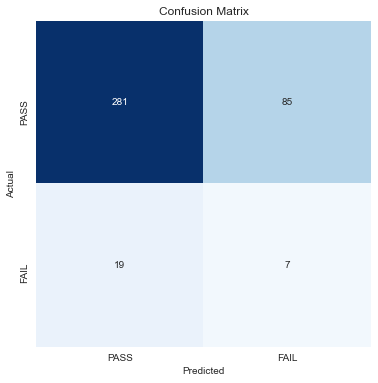

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.94      0.77      0.84       366
           0       0.08      0.27      0.12        26

    accuracy                           0.73       392
   macro avg       0.51      0.52      0.48       392
weighted avg       0.88      0.73      0.80       392



In [27]:
knn_clf = KNeighborsClassifier(algorithm='auto', n_neighbors = 1)
knn_clf.fit(X_train_smote, y_train_smote)

evaluate_model(knn_clf, X_test, y_test)

## Building SVC model, using GRID SEARCH, and getting Accuracy

Accuracy: 60.46%


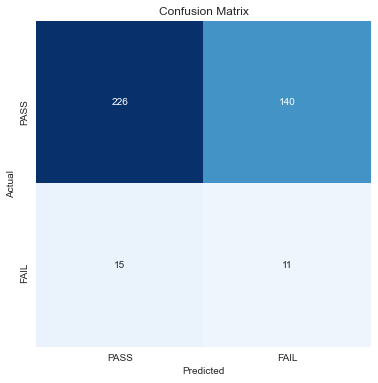

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.94      0.62      0.74       366
           0       0.07      0.42      0.12        26

    accuracy                           0.60       392
   macro avg       0.51      0.52      0.43       392
weighted avg       0.88      0.60      0.70       392



In [28]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train_smote, y_train_smote)
evaluate_model(svc_clf, X_test, y_test)

## Building RandomForest, using GRID SEARCH, and getting Accuracy


from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_smote, y_train_smote)

param_grid_rf = {'max_depth': [3,4,5],
             'max_features': [5,7,9],
             'min_samples_split': [4,5,6],
             'bootstrap': [True, False],
             'criterion':['gini', 'entropy']}

gs_rf = GridSearchCV(rf_clf, param_grid_rf, cv=10)
gs_rf.fit(X_train_smote, y_train_smote)

gs_rf.best_params_

Accuracy: 91.07%


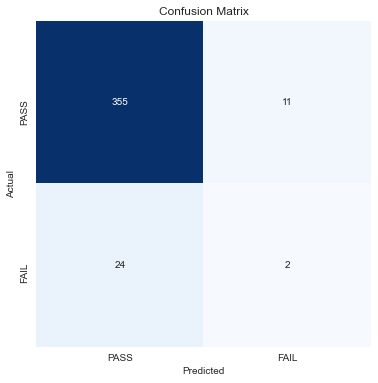

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.94      0.97      0.95       366
           0       0.15      0.08      0.10        26

    accuracy                           0.91       392
   macro avg       0.55      0.52      0.53       392
weighted avg       0.88      0.91      0.90       392



In [29]:
rf_clf_tun = RandomForestClassifier(bootstrap=False, criterion='gini',max_depth=5, max_features=5, min_samples_split=6)
rf_clf_tun.fit(X_train_smote, y_train_smote)

evaluate_model(rf_clf_tun, X_test, y_test)

### Using RandomSearch CV on RandomForest model.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


rf_clf_rand = RandomForestClassifier(n_estimators=50)

param_grid = {'max_depth': sp_randint(1,11),
             'max_features': sp_randint(1,11),
             'min_samples_split': sp_randint(2,11),
             'bootstrap': [True, False],
             'criterion':['gini', 'entropy']}


samples = 10
randomCV = RandomizedSearchCV(rf_clf_rand, param_distributions=param_grid, n_iter=samples)

randomCV.fit(X_train_smote,y_train_smote)

randomCV.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 8,
 'min_samples_split': 10}

Accuracy: 93.11%


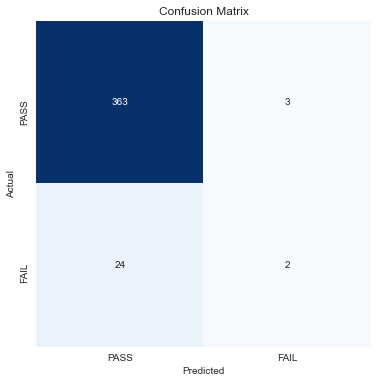

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.94      0.99      0.96       366
           0       0.40      0.08      0.13        26

    accuracy                           0.93       392
   macro avg       0.67      0.53      0.55       392
weighted avg       0.90      0.93      0.91       392



In [31]:
rf_clf_tun2 = RandomForestClassifier(bootstrap=True, criterion='gini',max_depth=9, max_features=9, min_samples_split=3)
rf_clf_tun2.fit(X_train_smote, y_train_smote)

evaluate_model(rf_clf_tun2, X_test, y_test)

In [32]:
rf_clf_tun2.score(X_test, y_test)

0.9311224489795918

In [33]:
y_test

60      1
995     1
1469    1
895     1
321     0
       ..
1292    1
98      1
527     1
810     1
765     1
Name: Pass/Fail, Length: 392, dtype: object

# Performing PCA on data

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
pca.fit(X)

PCA(n_components=6)

In [35]:
print(pca.explained_variance_)


[53415196.71568198 21746653.04722305  8248375.12800157  2073880.23269509
  1315399.1105698    467567.76862866]


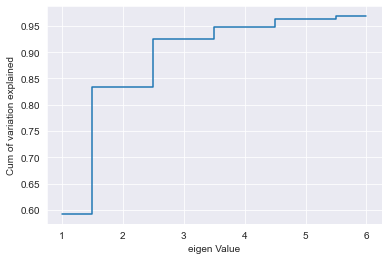

In [36]:
plt.step(list(range(1,7)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()


In [37]:
Xpca4 = pca.transform(X)


In [38]:
pd.DataFrame(Xpca4).head()

,0,1,2,3,4,5
0,-5183.896445,-3022.647594,688.386664,57.927544,349.282179,-41.216972
1,-1866.695876,-4021.676294,-1505.583129,199.254439,-640.432209,-46.172400
2,-3154.740523,-3461.979283,-1855.433740,-153.337306,-139.521180,-29.543566
3,-1983.434548,-598.028958,-1509.101953,-571.943332,286.164473,-68.000859
4,-3926.094302,-2343.842152,134.619993,-187.949614,-134.322817,-54.668859


### Train test split on PCA data

In [39]:
Xpca_train, Xpca_test, y_train2, y_test2 = train_test_split(Xpca4, y, test_size=0.25, random_state=1)

Accuracy: 93.37%


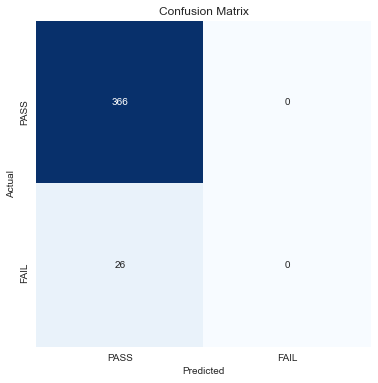

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.93      1.00      0.97       366
           0       0.00      0.00      0.00        26

    accuracy                           0.93       392
   macro avg       0.47      0.50      0.48       392
weighted avg       0.87      0.93      0.90       392



In [40]:
model = LogisticRegression()
model.fit(Xpca_train, y_train2)

evaluate_model(model, Xpca_test, y_test2)

Accuracy: 93.87%


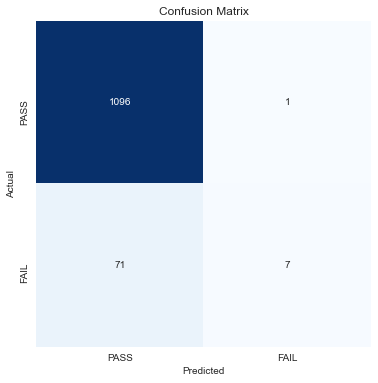

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.94      1.00      0.97      1097
           0       0.88      0.09      0.16        78

    accuracy                           0.94      1175
   macro avg       0.91      0.54      0.57      1175
weighted avg       0.93      0.94      0.91      1175



In [41]:
rf_pca = RandomForestClassifier(bootstrap=False, criterion='gini',max_depth=5, max_features=5, min_samples_split=6)
rf_pca.fit(Xpca_train, y_train2)

evaluate_model(rf_pca, Xpca_train, y_train)

#### We are not able to get good results yet, we shall try Random Oversampling method. after scaling

In [42]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [43]:
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
0,0.224309,0.849725,-0.436273,0.033555,-0.050580,0.0,-0.563790,0.266269,0.509826,1.128417,...,-0.229797,-0.135520,0.118699,-0.204890,-0.093207,-0.197113,-2.528283e-15,-2.759188e-15,-6.054371e-15,-1.665950e-15
1,1.107136,-0.382910,1.017137,0.153067,-0.060045,0.0,0.198217,0.322244,0.456999,0.022582,...,-0.263493,-0.460054,0.530203,0.406679,0.444706,0.385059,-9.601744e-01,4.118532e-01,2.501244e-01,1.156689e+00
2,-1.114158,0.799102,-0.481289,0.686213,-0.047906,0.0,-0.906210,0.255074,-0.260907,0.327183,...,-0.205046,-0.590505,-1.262780,0.022264,0.014375,0.029833,2.991151e+00,3.627063e+00,3.321419e+00,-1.791486e-01
3,-0.350312,-0.198875,-0.051547,-1.106948,-0.051290,0.0,0.503246,-0.013602,0.343218,-0.765408,...,-0.224950,-0.645708,-0.322199,-0.292257,-0.362164,-0.283417,-1.018947e-01,-1.789275e-01,-3.082928e-01,-2.752459e-01
4,0.242143,0.087526,1.117387,-0.158919,-0.047492,0.0,-0.115382,0.187905,0.545044,-0.149584,...,-0.230791,-0.454486,-5.906899,26.867231,27.071425,26.913347,-1.018947e-01,-1.789275e-01,-3.082928e-01,-2.752459e-01


In [44]:
X_train_sc, X_test_sc, y_train22, y_test22 = train_test_split(X_scaled, y, test_size=0.4, random_state=1)

In [45]:
X_test_sc

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
60,0.376098,2.474493,2.030496e-01,-3.462942e-01,-5.220477e-02,0.0,8.921636e-02,1.207362e-01,1.760067,1.135038,...,-0.233522,-0.543371,1.118066,-0.216539,-0.227686,-0.212914,-0.109992,0.582271,0.773640,0.086996
995,-0.436348,0.403477,-4.644773e-14,-8.793435e-15,-4.750874e-17,0.0,1.373629e-14,-3.417915e-14,0.238918,0.870168,...,-0.183894,-0.313931,0.353844,0.319312,0.068167,0.301440,-0.118089,0.457298,0.285025,0.030416
1469,-1.583003,0.645865,-4.644773e-14,-8.793435e-15,-4.750874e-17,0.0,1.373629e-14,-1.363774e+01,-0.275807,1.525722,...,-0.238872,-0.281378,1.029887,0.045562,0.041271,0.034223,-0.385289,1.650220,1.087750,0.913204
895,-0.785259,0.282408,-4.472428e-01,1.241957e+00,-5.367932e-02,0.0,-2.097825e+00,2.998539e-01,-0.698423,0.770841,...,-0.207795,0.243047,0.059912,0.127104,0.041271,0.122624,0.999294,-1.087821,-0.971413,-0.845777
321,-1.059977,0.378665,-1.313658e-01,4.475834e-01,-4.643854e-02,0.0,-3.221387e-01,8.715170e-02,0.413654,-0.434320,...,5.016547,0.453610,0.089306,0.121280,0.175749,0.112473,-0.352901,-0.781069,-0.971413,-0.464493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,-0.934870,-0.478419,3.036741e-01,3.640272e-01,-4.829465e-02,0.0,-9.661719e-01,-1.367453e-01,-0.328634,-0.772030,...,-0.228426,-0.219886,0.030519,-0.228188,-0.200790,-0.220465,0.173403,-0.758347,-0.727106,-0.620076
1260,-0.828005,-1.394104,-3.178660e-01,9.355378e-02,-3.547664e-02,0.0,-5.587799e-01,1.879054e-01,-1.414975,-0.103232,...,4.799817,5.966393,-0.968848,0.202822,0.068167,0.200650,-0.628198,1.831999,1.925376,1.468502
125,0.077148,-0.986510,-1.325029e-01,-7.511521e-01,-5.310162e-02,0.0,1.251902e-01,-8.077106e-02,-1.336412,-1.050144,...,-0.215828,-0.093585,-1.027634,-0.397098,-0.415956,-0.378446,-0.109992,2.434141,2.274387,0.944546
407,-0.450506,0.077426,-7.442036e-01,5.937022e-01,-4.522967e-02,0.0,-5.005538e-02,1.207362e-01,2.030975,0.082178,...,-0.253142,-0.494305,1.529571,-0.216539,-0.173894,-0.214256,-1.243569,-0.269817,-0.238491,1.423545


In [46]:
os = RandomOverSampler(sampling_strategy=1)
X_train_os, y_train_os = os.fit_resample(X_train_sc, y_train22)

rf_os = RandomForestClassifier()

param_grid = {'max_depth': sp_randint(1,11),
              'n_estimators':sp_randint(50,500),
             'max_features': sp_randint(5,500),
             'min_samples_split': sp_randint(2,50),
             'bootstrap': [True, False],
             'criterion':['gini', 'entropy']}


samples = 5
randomCV2 = RandomizedSearchCV(rf_os, param_distributions=param_grid, n_iter=samples)

randomCV2.fit(X_train_os,y_train_os)

randomCV2.best_params_

In [47]:
rf_os_tuned = RandomForestClassifier(n_estimators= 197, bootstrap=True, criterion='entropy',max_depth=10, max_features=291, min_samples_split=24)
rf_os_tuned.fit(X_train_os, y_train_os)



RandomForestClassifier(criterion='entropy', max_depth=10, max_features=291,
                       min_samples_split=24, n_estimators=197)

Accuracy: 92.66%


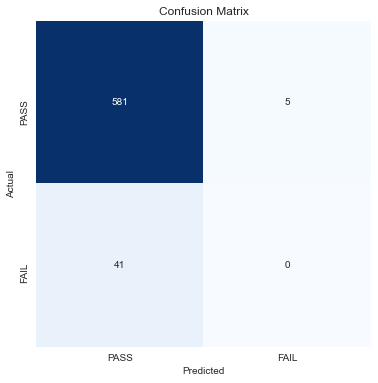

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.93      0.99      0.96       586
           0       0.00      0.00      0.00        41

    accuracy                           0.93       627
   macro avg       0.47      0.50      0.48       627
weighted avg       0.87      0.93      0.90       627



In [48]:
evaluate_model(rf_os_tuned, X_test_sc, y_test22)

In [49]:
X_test_sc

,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,557
60,0.376098,2.474493,2.030496e-01,-3.462942e-01,-5.220477e-02,0.0,8.921636e-02,1.207362e-01,1.760067,1.135038,...,-0.233522,-0.543371,1.118066,-0.216539,-0.227686,-0.212914,-0.109992,0.582271,0.773640,0.086996
995,-0.436348,0.403477,-4.644773e-14,-8.793435e-15,-4.750874e-17,0.0,1.373629e-14,-3.417915e-14,0.238918,0.870168,...,-0.183894,-0.313931,0.353844,0.319312,0.068167,0.301440,-0.118089,0.457298,0.285025,0.030416
1469,-1.583003,0.645865,-4.644773e-14,-8.793435e-15,-4.750874e-17,0.0,1.373629e-14,-1.363774e+01,-0.275807,1.525722,...,-0.238872,-0.281378,1.029887,0.045562,0.041271,0.034223,-0.385289,1.650220,1.087750,0.913204
895,-0.785259,0.282408,-4.472428e-01,1.241957e+00,-5.367932e-02,0.0,-2.097825e+00,2.998539e-01,-0.698423,0.770841,...,-0.207795,0.243047,0.059912,0.127104,0.041271,0.122624,0.999294,-1.087821,-0.971413,-0.845777
321,-1.059977,0.378665,-1.313658e-01,4.475834e-01,-4.643854e-02,0.0,-3.221387e-01,8.715170e-02,0.413654,-0.434320,...,5.016547,0.453610,0.089306,0.121280,0.175749,0.112473,-0.352901,-0.781069,-0.971413,-0.464493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,-0.934870,-0.478419,3.036741e-01,3.640272e-01,-4.829465e-02,0.0,-9.661719e-01,-1.367453e-01,-0.328634,-0.772030,...,-0.228426,-0.219886,0.030519,-0.228188,-0.200790,-0.220465,0.173403,-0.758347,-0.727106,-0.620076
1260,-0.828005,-1.394104,-3.178660e-01,9.355378e-02,-3.547664e-02,0.0,-5.587799e-01,1.879054e-01,-1.414975,-0.103232,...,4.799817,5.966393,-0.968848,0.202822,0.068167,0.200650,-0.628198,1.831999,1.925376,1.468502
125,0.077148,-0.986510,-1.325029e-01,-7.511521e-01,-5.310162e-02,0.0,1.251902e-01,-8.077106e-02,-1.336412,-1.050144,...,-0.215828,-0.093585,-1.027634,-0.397098,-0.415956,-0.378446,-0.109992,2.434141,2.274387,0.944546
407,-0.450506,0.077426,-7.442036e-01,5.937022e-01,-4.522967e-02,0.0,-5.005538e-02,1.207362e-01,2.030975,0.082178,...,-0.253142,-0.494305,1.529571,-0.216539,-0.173894,-0.214256,-1.243569,-0.269817,-0.238491,1.423545


In [50]:
y_test

60      1
995     1
1469    1
895     1
321     0
       ..
1292    1
98      1
527     1
810     1
765     1
Name: Pass/Fail, Length: 392, dtype: object

Accuracy: 60.46%


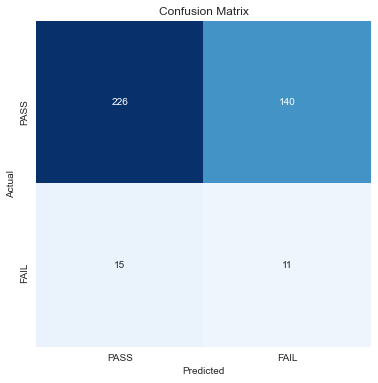

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.94      0.62      0.74       366
           0       0.07      0.42      0.12        26

    accuracy                           0.60       392
   macro avg       0.51      0.52      0.43       392
weighted avg       0.88      0.60      0.70       392



In [51]:
from sklearn.svm import SVC
svc_clf = SVC()
svc_clf.fit(X_train_smote, y_train_smote)
evaluate_model(svc_clf, X_test, y_test)

#### We can see that SVC with SMOTE data works best for this dataset

# Pickle the Model

In [52]:
import pickle


Best_model = svc_clf

svc_clf = svc_clf = SVC()
svc_clf = svc_clf.fit(X_train, y_train)

svc_clf.fit(X_train_smote, y_train_smote)
file = 'Best_model.pkl'
fileobj = open(file, 'wb')
pickle.dump(svc_clf, fileobj)
fileobj.close()


## Loading & Testing Pickled Model

In [53]:
file = 'Best_model.pkl'
fileobj = open(file,'rb')
Best_model = pickle.load(fileobj)
print (Best_model)

SVC()


# Testing the pickled model on Future Prediction

In [54]:
future_prediction = pd.read_excel('Future_predictions.xlsx')
future_prediction.head()

,Time,0,1,2,3,4,5,6,7,8,...,580,581,582,583,584,585,586,587,588,589
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100,97.6133,0.1242,1.5005,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100,102.3433,0.1247,1.4966,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100,95.4878,0.1241,1.4436,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100,104.2367,0.1217,1.4882,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100,100.3967,0.1235,1.5031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [55]:
future_prediction=future_prediction.drop('Time', axis=1)

In [56]:
future_prediction.isna().sum().sum()

520

In [57]:
missing2 = future_prediction.columns[future_prediction.isna().mean() >= 0.25]
missing

Index(['72', '73', '85', '109', '110', '111', '112', '157', '158', '220',
       '244', '245', '246', '247', '292', '293', '345', '346', '358', '382',
       '383', '384', '385', '492', '516', '517', '518', '519', '578', '579',
       '580', '581'],
      dtype='object')

In [58]:
missing2 = [ 72,  73,  85, 109, 110, 111, 112, 157, 158, 220, 244, 245, 246, 247,
       292, 293, 345, 346, 358, 382, 383, 384, 385, 492, 516, 517, 518, 519,
       562, 563, 564, 565]

In [59]:
future_prediction = future_prediction.drop(missing2, axis=1)

for column in future_prediction.columns:
        future_prediction[column] = future_prediction[column].fillna(future_prediction[column].mean())

In [60]:
future_prediction.shape

(18, 558)

In [61]:
X_train.shape

(1175, 558)

In [62]:
Best_model.predict(X_test)


array(['0', '1', '1', '1', '1', '0', '0', '0', '1', '0', '1', '1', '1',
       '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '1', '1', '1',
       '0', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1',
       '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0',
       '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0',
       '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1',
       '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0',
       '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1',
       '1', '0', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0',
       '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0',
       '1', '1', '0', '1', '0', '1', '1', '0', '1', '1', '1', '1', '1',
       '1', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1',
       '1', '1', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1',
       '0', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '1

In [63]:
results = pd.DataFrame(Best_model.predict(X_test))
results

,0
0,0
1,1
2,1
3,1
4,1
...,...
387,0
388,1
389,1
390,1


# Conclusion & Improvisation

#### The target data was highly imbalanced, this resulted in failure in predicting 'Fail' in most of the models built.

#### SVC Model, with SMOTE data worked better than all the other hypertuned models. 

#### High oversampling had to be done, which should be avoided to get authentic results. 

#### A lot of missing values were present in data.

#### A lot of columns had a lot of null values, data cleaning was required.
